In [60]:
import os
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data as D
import numpy as np

In [81]:
img_data = torchvision.datasets.ImageFolder("/home/ais/Desktop/archive/simpsons_dataset/",
                                            transform=transforms.Compose([
                                                transforms.Resize((256,256)),
                                                #transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
                                                #transforms.RandomRotation(15), # 隨機旋轉圖片
                                                #transforms.CenterCrop(256),
                                    
                                                transforms.ToTensor()])  
                                            ) #PIL讀取的影像為RGB順序，cv2讀取的影像為BGR順序

print(len(img_data))

data_loader = torch.utils.data.DataLoader(img_data, batch_size=32,shuffle=True,num_workers=4)


print(len(data_loader))


#train_set, val_set = torch.utils.data.random_split(data_loader, [600, 55])

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


20933
655


In [82]:
#split data to train and valid
data_len=len(img_data)
train_len = int(0.7*data_len)
test_len = data_len - train_len
trainset, testset = D.random_split(img_data, lengths=[train_len, test_len])



train_loader=torch.utils.data.DataLoader(trainset, batch_size=32,shuffle=True,num_workers=4)
valid_loader=torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True,num_workers=4)

In [83]:
examples = enumerate(data_loader)

batch_idx, (example_data, example_targets) = next(examples)

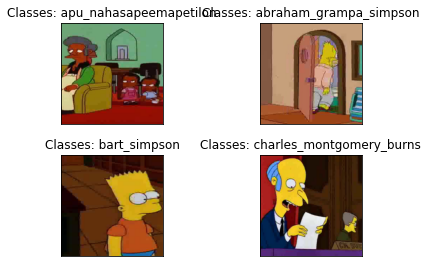

In [84]:
to_pil_image = transforms.ToPILImage()
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(to_pil_image(example_data[i]))
    #plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.title("Classes: {}".format(img_data.classes[example_targets[i]]))
    plt.xticks([])
    plt.yticks([])


In [54]:
#DNN MODEL
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=256*256*3, out_features=1280),
            nn.ReLU(),
            nn.Linear(in_features=1280, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=42),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)


net = Net().to(device)
print(net)

Net(
  (main): Sequential(
    (0): Linear(in_features=196608, out_features=1280, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1280, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=42, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


In [96]:
# CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1 , input_shape=(3,256,256) formula=(input+2*padding-kernel_size/stride)+1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, stride=1, padding=0) #output_shape=(128,252,252) 
        self.batn1=nn.BatchNorm2d(128)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(128,126,126) #(256/2)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=0) #output_shape=(256,122,122)
        self.batn2=nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(256,56,56)
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=0) #output_shape=(128,54,54)
        self.batn3=nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU() # activation
        # Max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) #output_shape=(128,27,27)
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0) #output_shape=(64,25,25)
        self.batn4=nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU() # activation
        # Max pool 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(8,12,12) or (8,13,13)
        # Fully connected 1 ,#input_shape=(8*13*13) is ok
        self.fc1 = nn.Linear(64 * 13 * 13, 512) 
        self.relu5 = nn.ReLU() # activation
        self.fc2 = nn.Linear(512, 42) 
        #self.output = nn.Softmax(dim=1) 
        
    
    def forward(self, x):
        out = self.cnn1(x) # Convolution 1
        out = self.batn1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1
        out = self.cnn2(out) # Convolution 2
        out = self.batn2(out)
        out = self.relu2(out) 
        out = self.maxpool2(out) # Max pool 2
        out = self.cnn3(out) # Convolution 3
        out = self.batn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out) # Max pool 3
        out = self.cnn4(out) # Convolution 4
        out = self.batn4(out)
        out = self.relu4(out)
        out = self.maxpool4(out) # Max pool 4
        out = out.view(out.size(0), -1) # last CNN faltten con. Linear NN
        out = self.fc1(out) # Linear function (readout)
        out = self.fc2(out)
        #out = self.output(out)

        return out
    
model = CNN_Model().to(device)
print(model)

CNN_Model(
  (cnn1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
  (batn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (batn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (batn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (batn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2,

In [98]:
batch=32
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0001 )

for epoch in range(100):  # loop over the dataset multiple times

    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        #inputs = inputs.view(inputs.shape[0], -1) for DNN
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_acc += np.sum(np.argmax(outputs.cpu().data.numpy(), axis=1) == labels.cpu().numpy())
        #print(np.argmax(outputs.cpu().data.numpy(), axis=1) == labels.cpu().numpy())
        train_loss += loss.item()
        # print statistics
        #running_loss += loss.item()
        #if i % 300 == 299:    # print every 2000 mini-batches
         #   print('[%d, %5d] loss: %.3f' %
         #         (epoch + 1, i + 1, running_loss / 300))
         #   running_loss = 0.0
            
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            valid_inputs,valid_labels = data[0].to(device), data[1].to(device)
            outputs = model(valid_inputs)
            loss = criterion(outputs, valid_labels)
            
            val_acc += np.sum(np.argmax(outputs.cpu().data.numpy(), axis=1) == valid_labels.cpu().numpy())
            val_loss += loss.item()
            
        print(f'epoch:{epoch+1} training loss={round(train_loss/train_loader.__len__(),3)} training accuracy={round(train_acc/(train_loader.__len__()*batch),3)*100}%  validation loss={round(val_loss/valid_loader.__len__(),3)} validation accuracy={round(val_acc/(valid_loader.__len__()*batch),3)*100}%')
print('Finished Training')

epoch:1 training loss=2.377 training accuracy=39.5%  validation loss=1.751 validation accuracy=52.900000000000006%
epoch:2 training loss=1.457 training accuracy=60.199999999999996%  validation loss=1.398 validation accuracy=62.1%
epoch:3 training loss=1.075 training accuracy=70.3%  validation loss=1.255 validation accuracy=65.8%
epoch:4 training loss=0.791 training accuracy=77.7%  validation loss=1.125 validation accuracy=71.0%
epoch:5 training loss=0.572 training accuracy=83.7%  validation loss=1.137 validation accuracy=71.5%
epoch:6 training loss=0.391 training accuracy=88.8%  validation loss=1.122 validation accuracy=73.1%
epoch:7 training loss=0.253 training accuracy=92.60000000000001%  validation loss=1.224 validation accuracy=73.1%
epoch:8 training loss=0.177 training accuracy=94.5%  validation loss=1.4 validation accuracy=73.6%
epoch:9 training loss=0.124 training accuracy=96.2%  validation loss=1.397 validation accuracy=73.6%
epoch:10 training loss=0.093 training accuracy=97.1%